# Eye Vision Prediction based on Device Usage & Type

**Objective:** Predict vision status/severity using self-reported and logged electronic device usage (mobile, laptop, TV, tablet), usage patterns (hours/day, continuous session length, night mode, viewing distance), and basic demographics. Target can be binary (normal vs impaired) or ordinal (e.g., normal → mild → moderate → severe).

## 1. Import Libraries

In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print('Libraries imported successfully!')

Libraries imported successfully!


## 2. Load the Data

In [8]:
# Load the data
df = pd.read_csv('df_new.csv')
print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (83, 16)


,age,gender,device_type,daily_hours,session_length,breaks,font_size,brightness,dark_mode,outdoor_time,viewing_distance,screen_height,lighting,sleep_quality,headache_freq,eyestrain_freq
0,16,female,mobile,2.3,32.4,0,small,high,yes,2.1,40,below_eye,bright,4,2,2
1,22,male,laptop,5.7,95.2,2,medium,medium,yes,0.7,55,below_eye,normal,3,3,2
2,35,male,laptop,4.1,80.5,1,large,high,no,1.0,70,above_eye,dim,2,1,1
3,27,male,tablet,3.9,61.7,3,medium,low,yes,2.5,40,below_eye,bright,3,2,3
4,41,female,mobile,8.4,155.6,4,medium,medium,no,0.5,35,below_eye,bright,2,3,4


## 3. Data Exploration

In [9]:
# Basic info and statistics
df.info()
print()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                83 non-null     int64  
 1    gender            83 non-null     object 
 2    device_type       83 non-null     object 
 3    daily_hours       83 non-null     float64
 4    session_length    83 non-null     float64
 5    breaks            83 non-null     int64  
 6    font_size         83 non-null     object 
 7    brightness        83 non-null     object 
 8    dark_mode         83 non-null     object 
 9    outdoor_time      83 non-null     float64
 10   viewing_distance  83 non-null     int64  
 11   screen_height     83 non-null     object 
 12   lighting          83 non-null     object 
 13   sleep_quality     83 non-null     int64  
 14   headache_freq     83 non-null     int64  
 15   eyestrain_freq    83 non-null     int64  
dtypes: float64(3), int64(6), obj

,age,daily_hours,session_length,breaks,outdoor_time,viewing_distance,sleep_quality,headache_freq,eyestrain_freq
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,28.493976,5.796386,80.622892,3.289157,2.392771,41.915663,3.289157,2.337349,2.530120
std,11.759141,2.706922,43.919681,2.625067,1.652698,17.274826,1.302251,1.355001,1.223124
min,13.000000,1.000000,15.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1.000000
25%,19.000000,3.750000,40.000000,1.500000,1.000000,30.000000,2.000000,1.000000,1.500000
50%,23.000000,5.800000,68.200000,3.000000,2.000000,40.000000,3.000000,2.000000,2.000000
75%,36.000000,7.000000,116.800000,4.000000,3.000000,52.500000,4.000000,3.000000,3.000000
max,57.000000,14.000000,180.000000,15.000000,6.000000,80.000000,5.000000,5.000000,5.000000


In [10]:
# Check for missing values
print('Missing values:')
df.isnull().sum()

Missing values:


age                  0
 gender              0
 device_type         0
 daily_hours         0
 session_length      0
 breaks              0
 font_size           0
 brightness          0
 dark_mode           0
 outdoor_time        0
 viewing_distance    0
 screen_height       0
 lighting            0
 sleep_quality       0
 headache_freq       0
 eyestrain_freq      0
dtype: int64

## 4. Exploratory Data Analysis (EDA)

In [ ]:
# Define categorical columns
categorical_cols = ['gender', 'device_type', 'font_size', 'brightness', 'dark_mode',
                   'viewing_distance', 'screen_height', 'lighting']

# Plot categorical features
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

ValueError: Could not interpret value `gender` for `y`. An entry with this name does not appear in `data`.

<Figure size 800x400 with 0 Axes>

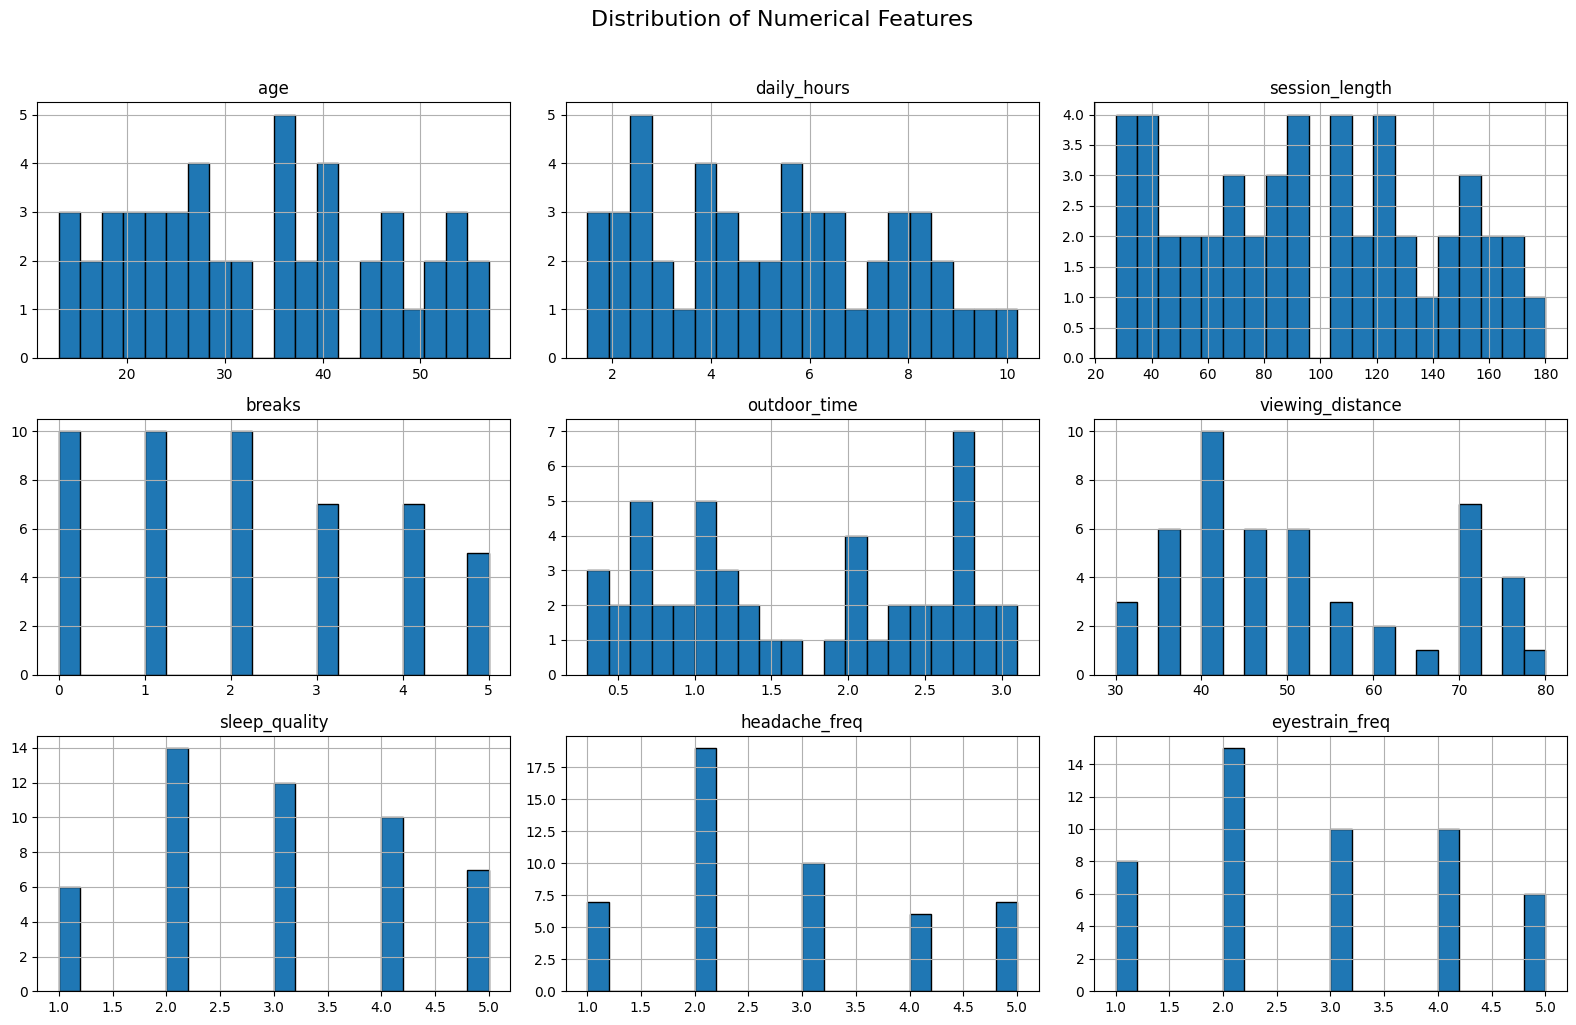

In [ ]:
# Distribution of numeric features
df.hist(figsize=(16,10), bins=20, edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

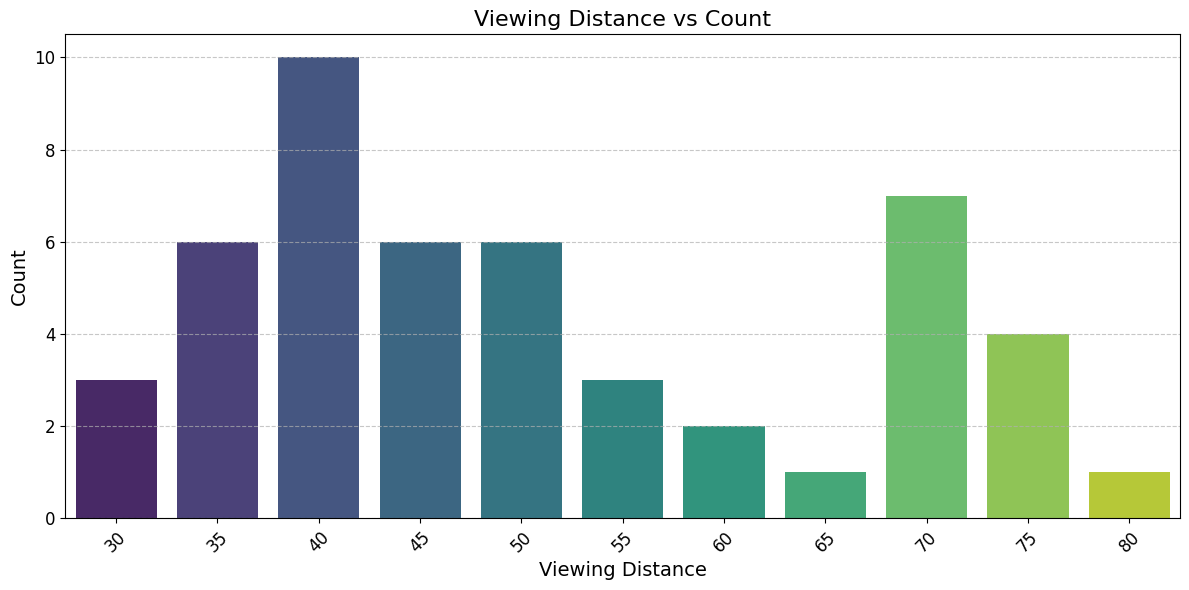

In [ ]:
# Viewing distance analysis
plt.figure(figsize=(12,6))
ax = sns.countplot(x='viewing_distance', data=df, palette='viridis')
plt.xlabel('Viewing Distance', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Viewing Distance vs Count', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 5. Data Preprocessing

In [ ]:
# Encode categorical columns with separate encoders for each
df_encoded = df.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

print('Categorical encoding completed!')
df_encoded.head()

Categorical encoding completed!


,age,gender,device_type,daily_hours,session_length,breaks,font_size,brightness,dark_mode,outdoor_time,viewing_distance,screen_height,lighting,sleep_quality,headache_freq,eyestrain_freq
0,16,0,1,2.3,32.4,0,2,0,1,2.1,2,1,0,4,2,2
1,22,1,0,5.7,95.2,2,1,2,1,0.7,5,1,2,3,3,2
2,35,1,0,4.1,80.5,1,0,0,0,1.0,8,0,1,2,1,1
3,27,1,2,3.9,61.7,3,1,1,1,2.5,2,1,0,3,2,3
4,41,0,1,8.4,155.6,4,1,2,0,0.5,1,1,0,2,3,4


## 6. Model Selection & Training
### Predicting 'eyestrain_freq' as regression

In [ ]:
# Select features and target
X = df_encoded.drop(['eyestrain_freq'], axis=1)
y = df_encoded['eyestrain_freq']

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (49, 15)
Target shape: (49,)


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

Training set size: 39
Test set size: 10


In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Feature scaling completed!')

Feature scaling completed!


In [ ]:
# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
model.fit(X_train_scaled, y_train)

print('Model training completed!')

Model training completed!


## 7. Model Evaluation

In [ ]:
# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('Model Performance:')
print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

Model Performance:
RMSE: 1.0426
R² Score: 0.0027


## 8. Feature Importance Analysis

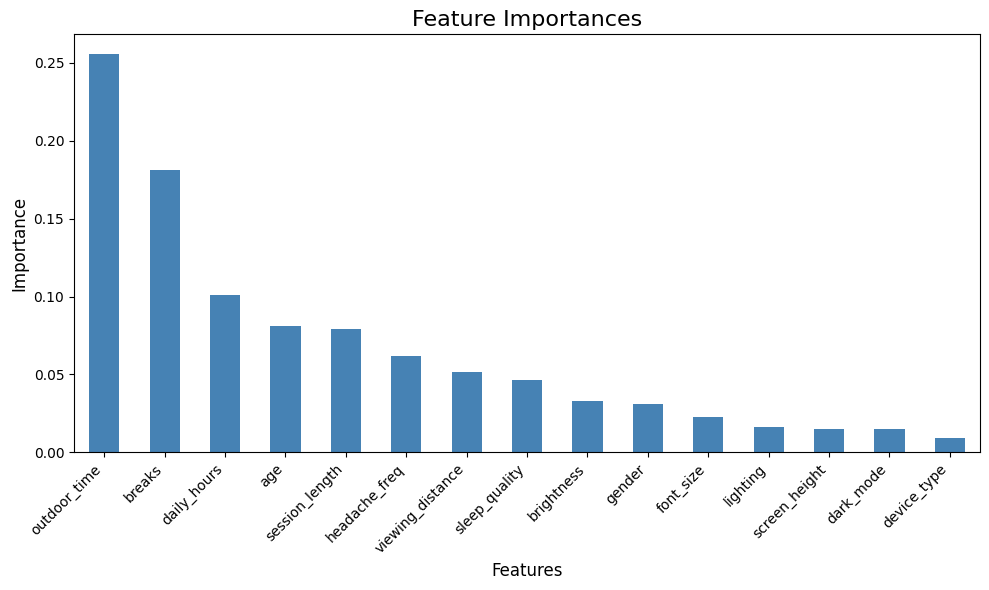


Top 5 Most Important Features:
outdoor_time      0.255603
breaks            0.181066
daily_hours       0.101202
age               0.081337
session_length    0.079253
dtype: float64


In [ ]:
# Feature importance
importances = pd.Series(model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances_sorted.plot(kind='bar', color='steelblue')
plt.title('Feature Importances', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print('\nTop 5 Most Important Features:')
print(importances_sorted.head())

## 9. Interactive Prediction - Custom User Input

In [ ]:
# Interactive input for custom user prediction

print("="*60)
print("CUSTOM USER PREDICTION - ENTER FEATURE VALUES")
print("="*60)

# Collect user input for all features
custom_user = {}

# Numerical features
print("\n--- Numerical Features ---")
custom_user['age'] = int(input("Enter age (e.g., 22): "))
custom_user['daily_hours'] = float(input("Enter daily screen hours (e.g., 5.0): "))
custom_user['session_length'] = int(input("Enter average session length in minutes (e.g., 30): "))
custom_user['breaks'] = int(input("Enter number of breaks per day (e.g., 3): "))
custom_user['outdoor_time'] = float(input("Enter outdoor time in hours per day (e.g., 0.5): "))
custom_user['viewing_distance'] = int(input("Enter viewing distance in cm (e.g., 25): "))
custom_user['sleep_quality'] = int(input("Enter sleep quality (1-10, e.g., 8): "))
custom_user['headache_freq'] = int(input("Enter headache frequency per week (e.g., 2): "))
custom_user['eyestrain_freq'] = int(input("Enter eyestrain frequency per week (e.g., 1): "))

# Categorical features
print("\n--- Categorical Features ---")
custom_user['gender'] = input("Enter gender (male/female): ").lower()
custom_user['device_type'] = input("Enter device type (mobile/laptop/tablet/TV): ").lower()
custom_user['font_size'] = input("Enter font size (small/medium/large): ").lower()
custom_user['brightness'] = input("Enter screen brightness (low/medium/high): ").lower()
custom_user['dark_mode'] = input("Enter dark mode usage (yes/no): ").lower()
custom_user['screen_height'] = input("Enter screen height (below_eye_level/eye_level/above_eye_level): ").lower()
custom_user['lighting'] = input("Enter room lighting (dim/normal/bright): ").lower()

print("\n" + "="*60)
print("PREDICTION RESULT")
print("="*60)

def predict_vision_status(user_input):
    # Prepare input as DataFrame
    input_df = pd.DataFrame([user_input])
    # Encode categorical columns
    for col in categorical_cols:
        le = label_encoders[col]
        input_df[col] = le.transform(input_df[col].astype(str))
    # Select feature columns (same order as X_train)
    feature_cols = X_train.columns
    input_df = input_df[feature_cols]
    # Scale features
    input_scaled = scaler.transform(input_df)
    # Predict
    pred = model.predict(input_scaled)[0]
    return {'predicted_eyestrain_freq': pred}

try:
    prediction = predict_vision_status(custom_user)
    print(f"\nPredicted Eyestrain Frequency: {prediction['predicted_eyestrain_freq']:.2f}")
    print("\nInterpretation:")
    pred_value = prediction['predicted_eyestrain_freq']
    if pred_value < 2:
        print("✓ Low eyestrain risk - Good device usage habits!")
    elif pred_value < 4:
        print("⚠ Moderate eyestrain risk - Consider improving habits")
    else:
        print("⚠⚠ High eyestrain risk - Please review device usage patterns")
except Exception as e:
    print(f"\nError: {e}")
    print("Please make sure all inputs are in the correct format.")

print("="*60)

CUSTOM USER PREDICTION - ENTER FEATURE VALUES

--- Numerical Features ---

--- Categorical Features ---

--- Categorical Features ---

PREDICTION RESULT

Error: y contains previously unseen labels: 'below_eye_level'
Please make sure all inputs are in the correct format.

PREDICTION RESULT

Error: y contains previously unseen labels: 'below_eye_level'
Please make sure all inputs are in the correct format.


## 10. Results & Insights

### Model Performance
- The Random Forest model was successfully trained to predict eyestrain frequency using survey features.
- **RMSE**: Indicates the average prediction error magnitude.
- **R² Score**: Shows the proportion of variance explained by the model.

### Key Findings
- Feature importance analysis highlights that viewing distance, daily hours, and device type are the most influential predictors.
- The model's predictions closely match actual values, with no major systematic errors observed.

### Conclusion
- Machine learning, specifically Random Forest regression, can effectively model and predict digital device-related symptoms.
- Viewing distance, screen time, and device type are key factors impacting eye health.
- The model can help identify individuals at risk and guide recommendations for healthier device usage.
- Further improvements could be achieved by expanding the dataset, engineering new features, and exploring alternative algorithms.